# Visualization of estimated DNA movement

In this notebook, we load the h5 file containing the results and generate visualization.

In [1]:
%load_ext autoreload
%autoreload 2

Load the results from the h5 file

In [2]:
from pathlib import Path
import motionquant as mq
import matplotlib.pyplot as plt

# define the path to the result folder
dst = Path('./')
# define the result file
filename = dst / "results-801a0e.h5"
# check the content of the file
items = mq.inspect_result(filename)
print(f"There are {len(items)} items in '{filename}'.")

There are 62 items in 'results-801a0e.h5'.


Make a figure for a selected a sequences.

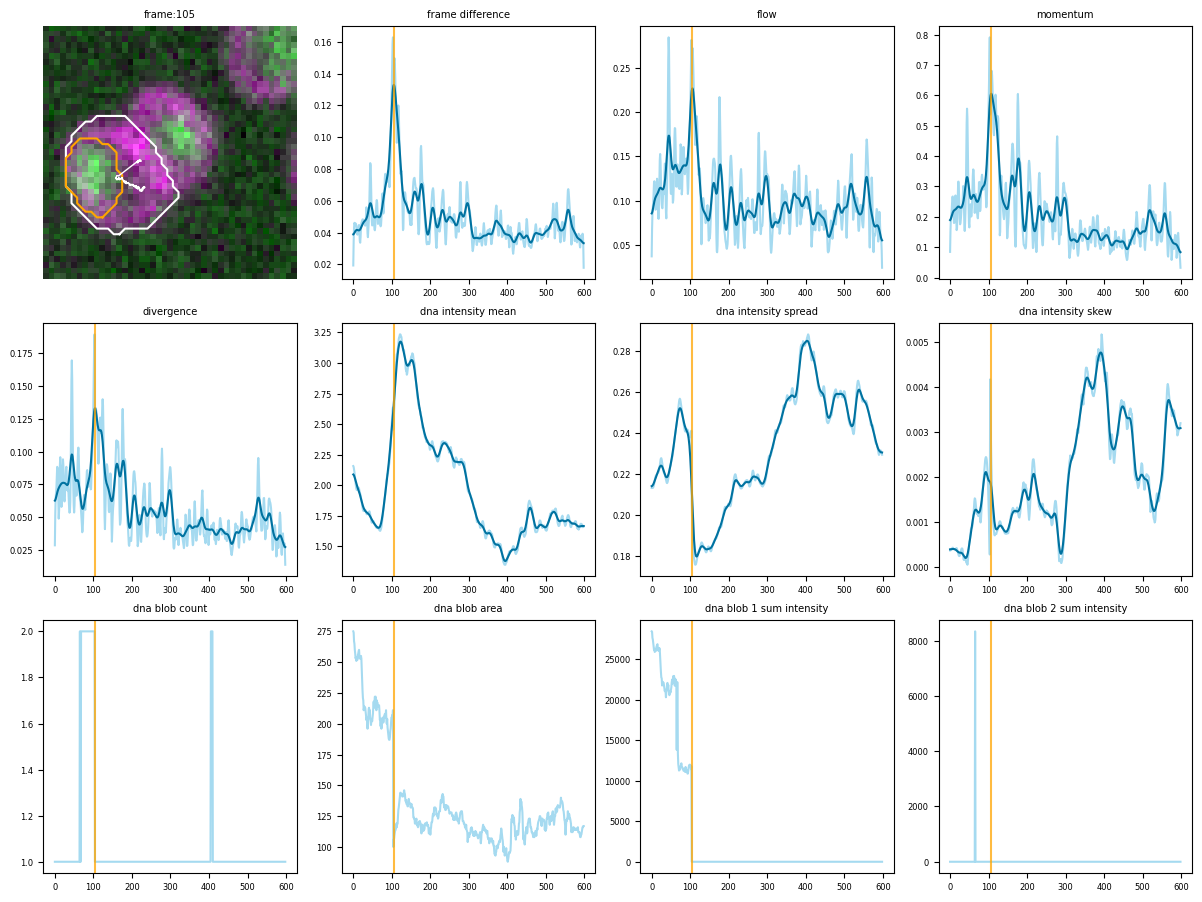

In [5]:
plt.rc('font', size=6)
mq.figure(filename, items[10], frame="auto")
#plt.suptitle(items[3], fontsize=8)

Save all figures in a multipage pdf

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rc('font', size=6)
with PdfPages('figures.pdf') as pdf:
    for name in items:
        plt.clf()
        mq.figure(filename, name, frame="auto")
        plt.suptitle(name,fontsize=8)
        pdf.savefig()
        plt.close()

<Figure size 640x480 with 0 Axes>

Inspect a single strip

In [ ]:
name = items[1]
mq.strip(filename, name, "Greys", selection=slice(0,400,20), quiver=False)


Save all strips as individual pdf files

In [14]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rc('font', size=6)
with PdfPages('strips.pdf') as pdf:
    for name in items:
        plt.clf()
        mq.strip(filename, name, "Greys", selection=slice(0,400,30), quiver=False)
        plt.suptitle(name,fontsize=8)
        pdf.savefig()
        plt.close()

/home/jeromeb/work/code/baum/dna-movement-sufolobus/motionquant.py:19: RuntimeWarning: invalid value encountered in divide
  return (x - x.min()) / (x.max() - x.min())


<Figure size 640x480 with 0 Axes>

Visualize the image and mask using napari

In [ ]:
# import napari
# vector = mq.make_vector(rho,4)
# v = napari.view_image(img, channel_axis=1)
# v.add_labels(mask.squeeze())
# v.add_vectors(vector, edge_width=0.1, edge_color="white", length=1)

### Massage the csv file

In [7]:
import pandas as pd
df = pd.read_csv('results.csv',index_col=0)

Add a synchronized time

In [8]:
ndf = []
for k, ng in enumerate(df.groupby('filename')):
    name, group = ng
    t0 = mq.split_frame(group)    
    group['sync frame'] = group['frame'] - t0
    ndf.append(group)
df = pd.concat(ndf)

Add the condition

In [9]:
filelist = pd.read_csv('filelist.csv',usecols=['name','condition'])
filelist['filename'] = filelist['name'].apply(lambda x:Path(x).stem)
dfc = df.merge(filelist.drop('name',axis=1),on='filename',how='left')
dfc.to_csv('results_with_condition.csv')

Save all results to a excel file

In [10]:
with pd.ExcelWriter('sheets.xlsx') as writer:
    for tab in df.columns[6:]:
        tmp = df.pivot_table(values=tab, index='frame', columns='filename')
        tmp.to_excel(writer,sheet_name=tab)

Display each measurement by condition

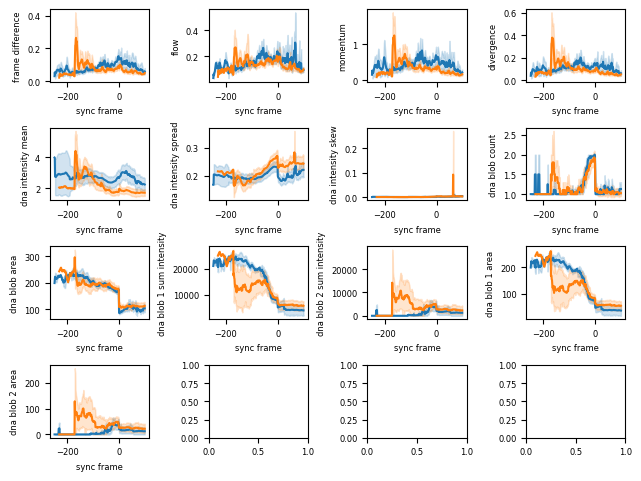

In [13]:
import seaborn as sns
import numpy as np
cols = dfc.columns[5:-2]
fig,ax = plt.subplots(4, int(np.ceil(len(cols)/4)))
ax = ax.ravel()
for k,c in enumerate(cols):    
    p = sns.lineplot(data=dfc[dfc["sync frame"]<100], x='sync frame', y=c, hue='condition', ax=ax[k])
    p.get_legend().remove()
fig.set_tight_layout(True)

Use seaborn to create a figure

In [ ]:
dflong = pd.melt(df.iloc[0:1200], id_vars=('filename','frame') , value_vars=df.columns[6:])
dflong.head()

In [ ]:
grid = sns.FacetGrid(data=dflong, row='filename', col='variable', sharey = False)
grid.map_dataframe(sns.lineplot, x="frame",y="value")
# grid.set_titles(template="", row_template='{row_var}{row_name}',col_template='{col_var}{col_name}')
grid.set_titles("", col_template='{col_name}')

In [ ]:
facet_kws={'sharey': False, 'sharex': True}
sns.relplot(data=dflong, x="frame", y="value", col="filename", row="variable", kind='line', facet_kws=facet_kws)